In [1]:
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import json
import cv2
import os
import sys
sys.path.append('../utils')

from train_eval import Evaluation

root_directory = Path("../data")
images_directory = root_directory / "images"
annots_directory =  root_directory / "annotations"
bbox_directory =  root_directory / "annotations-bbox"
masks_directory =  root_directory / "annotations-seg"

<ipython-input-1-82e9636fbf6d>:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Register Dataset

In [2]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog

path_to_train = annots_directory / 'modanet_instance_segmentation_train.json'
path_to_test = annots_directory / 'modanet_instance_segmentation_test.json'


register_coco_instances('modanet_instance_segmentation_train', {}, path_to_train, images_directory)
register_coco_instances('modanet_instance_segmentation_test', {}, path_to_test, images_directory)

MetadataCatalog.get('modanet_instance_segmentation_train').set(
    thing_classes=['bag', 'dress', 'footwear', 'skirt', 'top', 'sunglasses', \
                   'headwear', 'shorts', 'pants', 'belt', 'outer', 'scarf', 'boots']
)
train_metadata = MetadataCatalog.get('modanet_instance_segmentation_train')

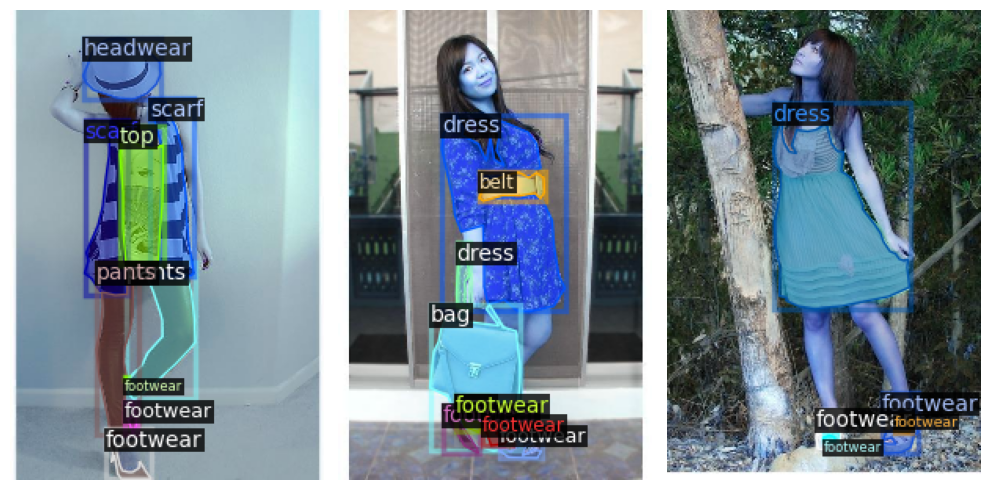

In [3]:
from detectron2.data.datasets import load_coco_json
dataset_dicts = load_coco_json("../data/annotations/modanet_instance_segmentation_train.json", "../data/images/")

f = Evaluation._show_n(dataset_dicts, train_metadata, predictions=False)

## Mask-RCNN

In [4]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2 import model_zoo

import random
random.seed(600)

### Training

In [5]:
from detectron2.config import get_cfg

model_yaml_path = 'COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml'

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(model_yaml_path))
cfg.OUTPUT_DIR = '../logs/maskrcnn_v3_101'
cfg.DATASETS.TRAIN = ('modanet_instance_segmentation_train',)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2

NUM_GPUS = 1
single_iteration = NUM_GPUS * cfg.SOLVER.IMS_PER_BATCH
iterations_for_one_epoch = len(dataset_dicts) / single_iteration

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_yaml_path)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13
cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = 14

In [15]:
model_zoo.get_checkpoint_url(model_yaml_path)

'https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x/138205316/model_final_a3ec72.pkl'

In [6]:
cfg.SOLVER.AMP.ENABLED = True
cfg.CUDNN_BENCHMARK = True

In [7]:
cfg.SOLVER.MAX_ITER, cfg.SOLVER.STEPS

(270000, (210000, 250000))

In [8]:
cfg.SOLVER.WEIGHT_DECAY = 0.0001
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.BASE_LR = 0.03
cfg.SOLVER.STEPS = (600, 800)

In [9]:
from detectron2.engine import DefaultTrainer
from trainer import MyTrainer

# os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[08/13 14:20:44 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[08/13 14:20:47 d2.data.datasets.coco]: Loading ../data/annotations/modanet_instance_segmentation_train.json takes 2.30 seconds.
WARNING [08/13 14:20:47 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/13 14:20:47 d2.data.datasets.coco]: Loaded 41803 images in COCO format from ../data/annotations/modanet_instance_segmentation_train.json
[08/13 14:20:48 d2.data.build]: Removed 0 images with no usable annotations. 41803 images left.
[08/13 14:20:49 d2.data.build]: Distribution of instances among all 13 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    bag     | 22459        |   dress    | 19835        |  footwear  | 69769        |
|   skirt    | 13882        |    top     | 44822        | sunglasses | 7075         |
|  headwear  | 4426         |   shorts   | 6914         |   pants    

### Evaluate

In [10]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.1

eval_tools = Evaluation(cfg, "modanet_instance_segmentation_test", default_pred_cfg=False)

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (14, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (14,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (52, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (52,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (13, 256, 1, 

In [11]:
# eval_tools.run_coco_eval()

WARNING [08/13 13:19:01 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/13 13:19:01 d2.data.datasets.coco]: Loaded 10451 images in COCO format from ../data/annotations/modanet_instance_segmentation_test.json


<Figure size 640x480 with 0 Axes>

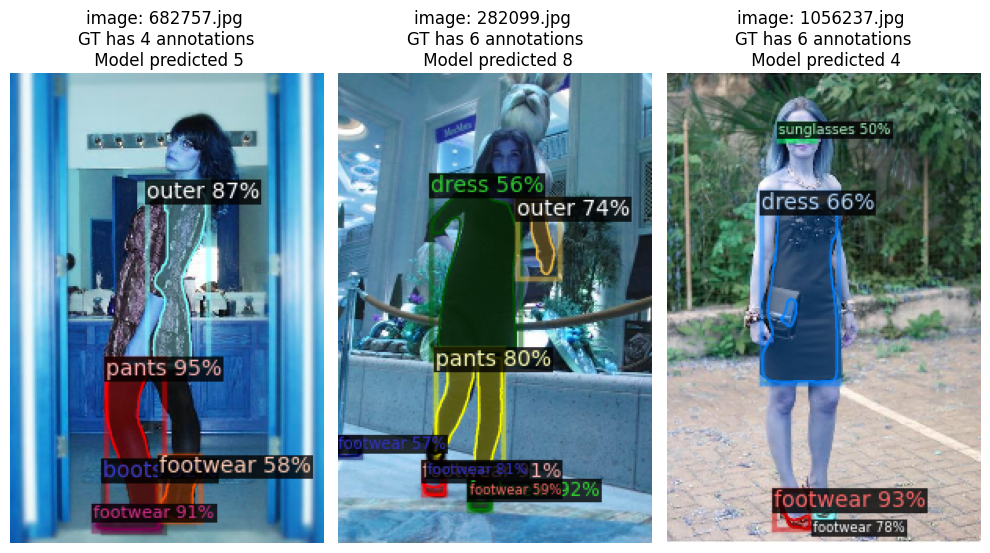

In [33]:
random.seed(600)

test_metadata = MetadataCatalog.get('modanet_instance_segmentation_test')
test_dataset_dicts = DatasetCatalog.get('modanet_instance_segmentation_test')

f = eval_tools.show_n(
    dataset_dicts=test_dataset_dicts, 
    metadata = train_metadata, 
    predictions = True, 
    add_info = True
)

In [20]:
f.savefig('test.png', dpi=600)

### Visualizations

In [37]:
for d in test_dataset_dicts:
    f = d["file_name"].split("/")[-1]
    if f == "282099.jpg":
        break

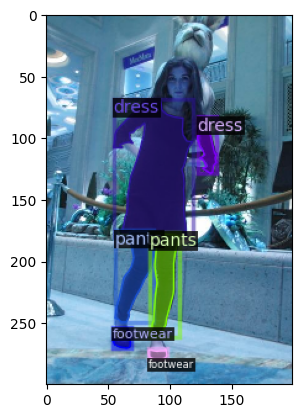

In [38]:
import cv2
import matplotlib.pyplot as plt

out = eval_tools.draw(cv2.imread(d["file_name"]), test_metadata, predictions=False, dataset_dict=d, predictor=eval_tools.predictor)
plt.imshow(out.get_image()[:, :, ::-1])
plt.show()

In [ ]:
test_annots = eval_tools.createAnnots(test_dataset_dicts, mapping = mapping, sample_ratio=2)

In [ ]:
# model_predictions = modanet_segmentation_dataset.create_annotation_set(
#     annotation_task = 'Instance Segmentation', name = 'exploration_preds_sampleratio2')

# modanet_segmentation_dataset.add_annotations(test_annots, annotation_set_id=model_predictions.id)

In [ ]:
modanet_segmentation_dataset.view()

In [14]:
!tensorboard --log-dir=../logs/maskrcnn_v2/

TensorFlow installation not found - running with reduced feature set.
usage: tensorboard [-h] [--helpfull] {serve,dev} ...
tensorboard: error: invalid choice: '../logs/maskrcnn_v2/' (choose from 'serve', 'dev')


In [11]:
!ls 

centermask.ipynb   mask-rcnn_new-baselines.ipynb  test.png
Exploration.ipynb  mask-rcnn_old-baseline.ipynb   tests_d2.ipynb
loss-plots.ipynb   model_final_14d201.pkl	  train_maskrcnn.py
mask-rcnn.ipynb    output
